<small><font color=gray>Авторы соревнования: <a href="https://www.hse.ru/org/persons/223985242" target="_blank">Алексей Болдырев</a>, <a href="https://www.hse.ru/staff/mekarpov" target="_blank">Максим Карпов</a>, <a href="https://www.hse.ru/staff/ramazyant" target="_blank">Тигран Рамазян</a>, <a href="https://www.linkedin.com/in/olegmelnikov/" target="_blank">Олег Мельников</a> ©2024</font></small><hr style="margin:0;background-color:silver">


**[<font size=6>🔢Какая цифра?</font>](https://www.kaggle.com/competitions/whatsthenumber)**.

Набор данных этого соревнования очень похож на [MNIST](https://en.wikipedia.org/wiki/MNIST_database), но здесь каждая строка представляет собой преобразованное изображение цифр `3` и `8` из разных шрифтов. Изображения цифр искажены, масштабированы, повернуты и т.д. и помещены на случайный фон. Набор данных состоит из обучающей выборки и тестовой выборки.

* **Обучающая выборка** (файл `trainYX.csv`) содержит 5000 изображений и столько же соответствующих им меток. Каждая строка обучающей выборки это:
   * индекс (идентификатор) в столбце `id`
   * метки `3` или `8` в столбце `y`
   * интенсивность яркости пикселей в остальных 1024 столбцах
      * интенсивность яркости каждого пикселя находится в диапазоне 0..255
   * признаки в каждой строке могут быть преобразованы в изображения цифр размером 32x32 пикселя
* **Тестовая выборка** (файл `testX.csv`) содержит 5000 новых изображений без меток:
   * индекс в столбце `id`
   * интенсивность яркости пикселей в 1024 столбцах
      * интенсивность яркости каждого пикселя находится в диапазоне 0..255

Созданная вами модель должна "обучиться" на **обучающей выборке** и уметь предсказать метки на **тестовой выборке**. Результатом работы вашего кода должен быть файл в формате `csv` из 5000 строк с теми же индексами, что были в тестовой выборке. Название файла отправки должно содержать только буквы латинского алфавита и цифры, например, `submission01.csv`.
Пример первых нескольких строк файла отправки:
```
id,y
5000,3
5001,8
5002,8
...
```
Затем вы отправляете этот файл на сайт соревнования [Какая цифра?](https://www.kaggle.com/competitions/whatsthenumber), используя кнопку "**Submit predictions**".

In [ ]:
# Альтернативный способ работы с соревнованием с использованием API kaggle
# from google.colab import drive; drive.mount('/content/drive')       # Раскомментируйте, если ваш kaggle.json хранится в корневой директории Google Drive

# !pip -q install --upgrade --force-reinstall --no-deps kaggle > log  # Обновите пакет kaggle (полную документацию см. на https://www.kaggle.com/docs/api)
# !mkdir -p ~/.kaggle                                                 # Папка .kaggle должна содержать файл kaggle.json, чтобы исполняемый файл kaggle мог правильно аутентифицировать вас на kaggle.com
# !cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json >log   # Сначала скачайте файл kaggle.json с сайта kaggle.com (на странице аккаунта) и поместите его в корень установленного Google Диска
# !cp kaggle.json ~/.kaggle/kaggle.json > log                         # Альтернативное расположение kaggle.json (без подключения к Google Drive)
# !chmod 600 ~/.kaggle/kaggle.json                                    # Предоставляйте полный доступ на чтение/запись к kaggle.json только владельцу аккаунта Kaggle
# !kaggle config set -n competition -v whatsthenumber                 # Название соревнования для следующих нескольких вызовов API kaggle
# !kaggle competitions download >> log                                # Загрузите набор данных соревнований в виде zip-файла
# !unzip -o *.zip >> log                                              # Набор данных соревнования копируется в виде одного файла и должен быть разархивирован
# !kaggle competitions leaderboard --show                             # Показать общедоступный рейтинг команд соревнования

In [ ]:
%reset -f
from IPython.core.interactiveshell import InteractiveShell as IS; IS.ast_node_interactivity = "all"
import pandas as pd, numpy as np, matplotlib.pyplot as plt, time
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
RunTimeLimit, t0 = 120, time.time() # ограничение по времени работы вашей модели и время начала работы
np.set_printoptions(linewidth=10000, precision=4, edgeitems=20, suppress=True)

class Timer():
  def __init__(self, lim:'RunTimeLimit'=120): self.t0, self.lim, _ = time.time(), lim, print(f'отсчет ⏳ начался. У вашей модели есть только {lim} секунд. Удачи!')
  def ShowTime(self):
    msg = f'Время выполнения {time.time()-self.t0:.0f} с'
    print(f'\033[91m\033[1m' + msg + f' > {self.lim} секунд на предельное время выполнения!!!\033[0m' if (time.time()-self.t0-1) > self.lim else msg)

pd.set_option('display.max_rows', 100, 'display.max_columns', 100, 'display.max_colwidth', 100, 'display.precision', 2, 'display.max_rows', 4)

sFile = 'https://github.com/afonsky/DataAnalysisSummerSchool-2024/raw/main/trainYX.zip'
dfYX = pd.read_csv(sFile, compression='zip', index_col='id')
dfYX


,y,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,...,975,976,977,978,979,980,981,982,983,984,985,986,987,988,989,990,991,992,993,994,995,996,997,998,999,1000,1001,1002,1003,1004,1005,1006,1007,1008,1009,1010,1011,1012,1013,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023,1024
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,3,227,233,237,235,233,233,230,226,232,235,241,245,239,229,227,233,232,229,226,227,230,232,232,230,248,235,242,247,238,242,246,231,230,234,237,235,234,234,229,223,229,231,237,242,240,232,231,235,235,...,229,233,219,227,234,237,238,239,237,232,230,224,229,236,232,228,232,234,241,234,230,232,234,233,235,238,241,245,240,237,240,236,235,244,237,244,238,222,221,235,240,234,237,227,233,240,230,223,227,229
1,8,232,250,252,238,228,238,244,241,252,253,251,225,252,252,202,242,242,203,254,254,226,252,254,252,239,242,238,216,244,249,254,240,211,207,229,209,231,244,255,255,246,255,245,210,249,235,187,243,242,...,193,240,242,186,234,249,211,246,255,248,255,255,246,220,215,226,210,218,229,255,255,245,211,237,247,247,252,255,255,227,249,248,198,248,241,201,252,252,225,252,254,253,243,245,240,216,243,247,251,237
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4998,3,241,242,243,241,239,238,238,240,242,242,242,242,242,240,239,238,238,236,237,243,246,243,241,242,240,239,239,240,241,242,241,240,238,240,241,240,238,238,239,240,244,244,244,243,241,238,236,234,235,...,217,219,224,228,233,239,244,245,244,242,241,240,239,238,238,237,237,238,241,242,241,238,240,243,241,237,240,237,237,238,236,230,227,229,231,233,236,241,245,246,244,242,240,240,239,238,238,239,239,239
4999,3,248,244,242,246,249,248,248,250,250,247,244,244,247,249,249,248,246,247,248,249,249,249,249,248,251,252,250,245,240,241,247,254,253,248,246,249,250,249,249,252,249,249,249,250,249,248,245,243,246,...,251,246,248,244,244,249,250,248,246,248,253,250,247,245,242,241,245,250,249,247,245,247,249,251,250,248,250,249,236,244,249,245,252,246,252,243,243,252,251,241,244,255,250,247,247,250,249,245,244,246


В этом тестовом файле не хватает столбца с метками цифр, которые вам нужно предсказать.

In [ ]:
dfX = pd.read_csv('https://github.com/afonsky/DataAnalysisSummerSchool-2024/raw/main/testX.zip', compression='zip', index_col='id')
dfX

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,...,975,976,977,978,979,980,981,982,983,984,985,986,987,988,989,990,991,992,993,994,995,996,997,998,999,1000,1001,1002,1003,1004,1005,1006,1007,1008,1009,1010,1011,1012,1013,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023,1024
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
5000,242,242,242,241,240,239,238,237,235,235,236,235,233,232,231,231,235,234,234,236,239,238,234,230,234,232,230,230,232,235,235,235,240,240,240,240,239,237,236,235,232,233,234,234,234,233,232,230,235,234,...,233,234,234,235,234,232,232,234,238,240,232,234,234,232,233,236,234,230,230,229,229,229,230,231,233,235,233,232,233,234,233,231,232,233,229,233,235,234,233,233,233,233,234,238,238,235,234,236,235,231
5001,243,230,235,224,240,227,238,235,232,211,238,240,229,238,229,228,222,241,231,254,231,224,231,241,236,241,221,224,242,210,222,230,228,231,223,242,231,238,224,227,235,225,244,234,223,240,236,230,233,243,...,219,245,233,255,227,240,234,248,237,222,239,228,241,237,238,243,228,237,252,241,226,248,209,235,237,248,241,222,253,222,246,225,242,240,249,197,233,234,224,203,243,229,226,242,247,252,238,222,235,243
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9998,248,247,248,240,228,236,252,255,221,216,255,250,231,226,211,252,255,217,217,244,249,247,230,214,255,253,238,229,239,246,245,248,247,246,251,247,237,244,254,252,253,235,252,255,255,255,240,255,255,232,...,244,255,250,255,243,249,238,252,237,248,244,248,244,250,255,240,229,245,249,246,247,239,229,237,252,254,214,222,246,255,226,227,212,255,255,210,236,230,253,255,204,228,253,255,235,208,236,255,248,245
9999,234,233,233,234,236,237,237,236,234,231,230,233,233,231,232,236,236,234,235,238,242,243,240,237,236,235,234,234,235,236,238,240,235,233,232,233,235,235,234,232,232,229,229,233,233,230,231,234,233,232,...,235,237,237,237,237,237,235,233,231,229,233,235,238,239,237,234,233,233,236,237,236,233,229,228,231,234,237,237,235,233,232,233,235,238,238,239,240,239,236,234,233,234,228,232,236,238,237,235,233,233


Вот несколько первых цифр.

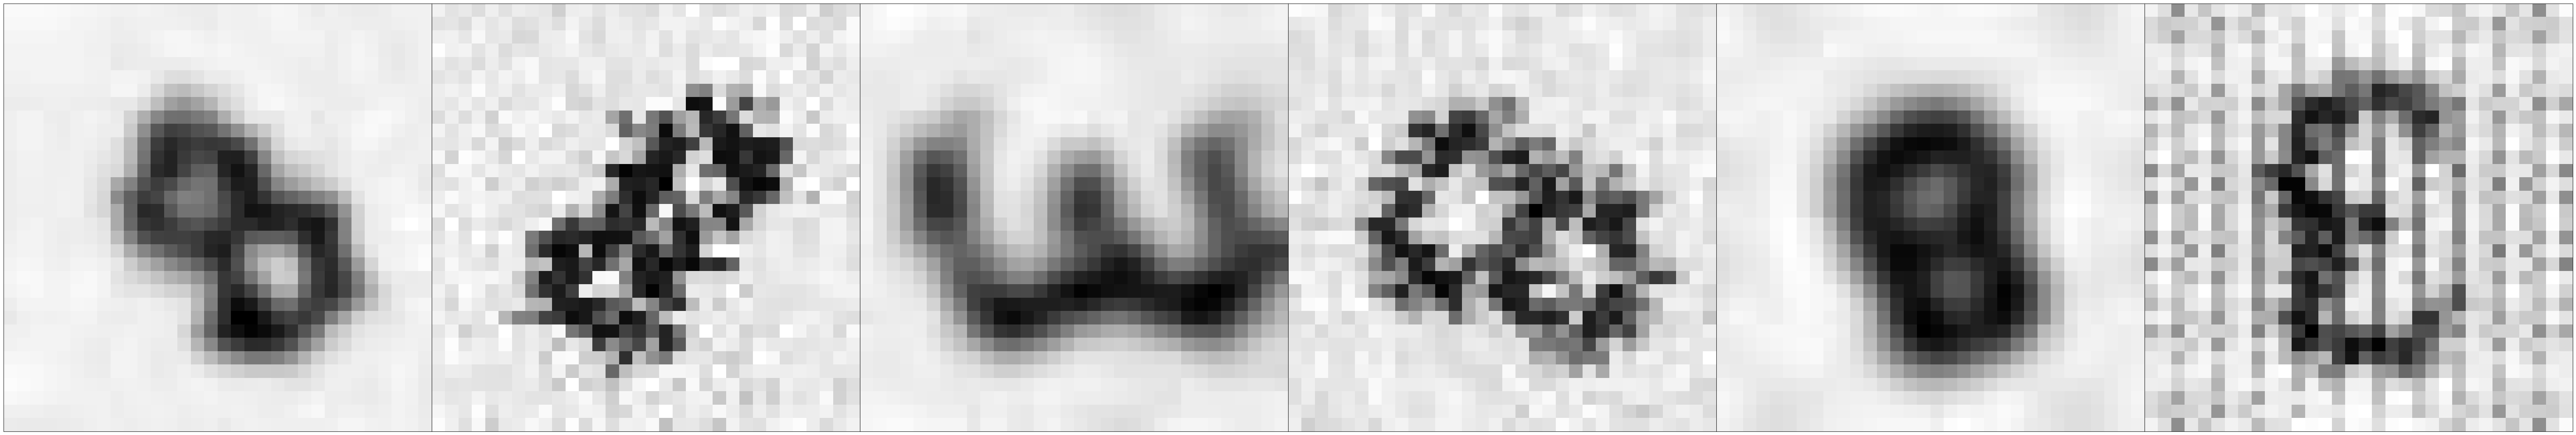

In [ ]:
X = dfX.values
n_col, w = 6, 32
_ = plt.figure(figsize=(6*12,12))
for i in range(n_col):
    ax = plt.subplot(1, n_col, i + 1)
    _ = plt.imshow(X[i,].reshape(w,w).astype('float'), cmap='gray')
    _, _ = plt.xticks([]), plt.yticks([]);
_ = plt.tight_layout(pad=0)
_ = plt.show()

In [ ]:
tmr = Timer()

отсчет ⏳ начался. У вашей модели есть только 120 секунд. Удачи!


<hr color=green size=40>

<font size=5>⏳</font> <strong><font color=green size=5>Ваш код, документация, идеи и отсчет времени - все записывается здесь...</font></strong>

<font color=green> **Раздел для участников соревнования** (между символами ⏳): добавьте сюда свой код и документацию.

## **Задача 1. Система предварительной обработки**

Объясните элементы вашей системы предварительной обработки, т.е. обработку признаков, создание подвыборок, кластеризацию, уменьшение размерности и т. д.
1. Почему вы выбрали эти элементы? (Что-то в разведочном анализе, подсказал предыдущий опыт...?)
1. Как вы оцениваете эффективность этих элементов?
1. Что еще вы пробовали, что сработало или не сработало?

**Ответ участника:**

## **Задание 2. Подход к моделированию**
Объясните свой подход к моделированию, то есть идеи, которые вы пробовали и почему считали их полезными.

1. Как эти решения помогали вам в моделировании?
1. Как вы оцениваете эффективность этих элементов?
1. Что еще вы пробовали, что сработало или не сработало?

**Ответ участника:**

Ниже приведена базовая модель, дающая результат `baseline` в лидерборде соревнования Какая цифра на kaggle.

In [ ]:
LR = LogisticRegression(random_state=0, n_jobs=-1).fit(dfYX.drop('y', axis=1), dfYX.y)
print(f'Точность (accuracy) в обучающем наборе: {LR.score(dfYX.drop("y", axis=1), dfYX.y):.3f}')
pY = dfX[['1']].rename(columns={'1':'y'}).copy()*0
pY['y'] = LR.predict(dfX)
pY.to_csv('baseline.csv')

Точность (accuracy) в обучающем наборе: 0.779


# **Ссылки:**

* Не забудьте сослаться на использованные источники в этом разделе. Как минимум, необходимо сослаться на учебники и статьи. Google Scholar позволяет легко скопировать/вставить формат цитирования APA для книг и публикаций. Также цитируйте StackOverflow, документацию по пакетам и другие значимые интернет-ресурсы, чтобы помочь своим коллегам учиться на них (и избежать претензий в плагиате).

<font size=5>⌛</font> <strong><font color=green size=5>Не превышайте ограничение времени, выделенного на работу вашей модели!</font></strong>

<hr color=green size=40>


In [ ]:
tmr.ShowTime()    # Измерьте время работы вашего кода. Не удаляйте этот код. Используйте как последнюю ячейку в тетрадке.

Время выполнения 7 с


## 💡**Стартовые идеи**

1. Настройка гиперпараметров модели
1. Попробуйте линейную и нелинейную нормализацию признаков:
   * сдвиг/масштабирование
   * возведение в степень
   * взятие логарифма
   * деление признаков на признаки
      * Исследуйте матрицу рассеяния
1. Попробуйте взаимодействие признаков более высокого порядка и полиномиальные признаки на небольшой подвыборке.
   * Затем определите ключевые признаки или выделите ключевые главные компоненты
   * Окончательная модель может быть обучена на большей или даже полной обучающей выборке
   * Для сокращения набора признаков можно использовать [PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html)
1. Проведите тщательный разведочный анализ данных:
   * ищите дополнения признаков, которые приводят к линейным границам принятия решений между классами
1. Оцените предсказания и сосредоточьтесь на плохо предсказанных "группах":
  1. Самые сильные неверные классификации
     * Там, где модель очень уверенно выдает неверную метку класса
  1. Оцените предсказания вблизи границ принятия решений
1. Имеют ли диаграммы рассеяния кусочно-линейную форму? Можно ли использовать отдельную линейную модель для каждого дианазона или линеаризовать модель при помощью преобразований?
1. Узнайте о наборе данных MNIST и соответствующих моделях.